# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as I
import torchsummary as summary

In [2]:
! git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [3]:
!ls
!pwd

1_zEMQPkGKjF5IiquiTSoyJw.jpeg  P1_Facial_Keypoints  sample_data
/content


In [4]:
key_pts_frame = pd.read_csv("./P1_Facial_Keypoints/data/training_frames_keypoints.csv")
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)
print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

print('Image Name',   image_name)
print('Landmarks shape:',key_pts.shape[0])
print("first 4 key: {}".format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]
Image Name Luis_Fonsi_21.jpg
Landmarks shape: 68
first 4 key: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [5]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


# Show some images

In [6]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:,0],key_pts[:,1], s=20, marker=".", c="m")

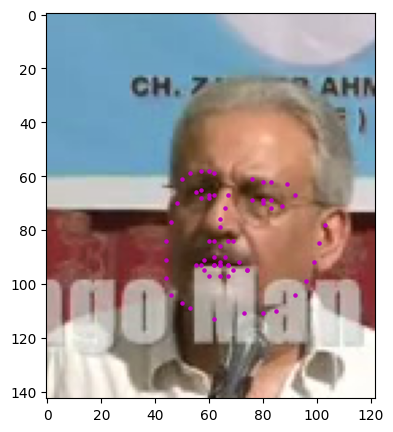

(143, 122, 4)


In [7]:
n = 222
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)
plt.figure(figsize=(5,5))
img = mpimg.imread(os.path.join("./P1_Facial_Keypoints/data/training/", image_name))
show_keypoints(img, key_pts)
plt.show()
print(img.shape)


## dataset loader and transformation

In [8]:
class FacialKeypointsDataset(Dataset):
    """Face Keypoints Dataset."""

    def __init__(self, csv_file, root_dir, transformation = None, train = True):
      """
      Args:
      csv_file (string): path to csv file with annotations
      root_dir (string): directory with all images
      transformation (callable, optional):  Optional transform to be applied
                                            on a sample.
      """
      self.key_pts_frame = pd.read_csv(csv_file)
      if train == True:
        self.root_dir = os.path.join(root_dir,"training/")
      else:
        self.root_dir = os.path.join(root_dir,"test/")
      self.transformation = transformation

    def __len__(self):
      return len(self.key_pts_frame)

    def __getitem__(self, idx):
      image_path = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx, 0])
      image = mpimg.imread(image_path)

      # if image has an alpha color channel, delete it
      if(image.shape[2] == 4):
            image = image[:,:,0:3]
      key_pts = self.key_pts_frame.iloc[idx, 1:].values
      key_pts = key_pts.astype('float').reshape(-1, 2)
      sample = {'image': image, 'keypoints': key_pts}
      if self.transformation:
            sample = self.transformation(sample)
      return sample



In [9]:
face_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                    root_dir='./P1_Facial_Keypoints/data')
print("length of dataset =", len(face_dataset))

length of dataset = 3462


0 (240, 195, 3) (68, 2)
1 (152, 128, 3) (68, 2)
2 (171, 179, 3) (68, 2)
3 (360, 346, 3) (68, 2)
4 (192, 192, 3) (68, 2)


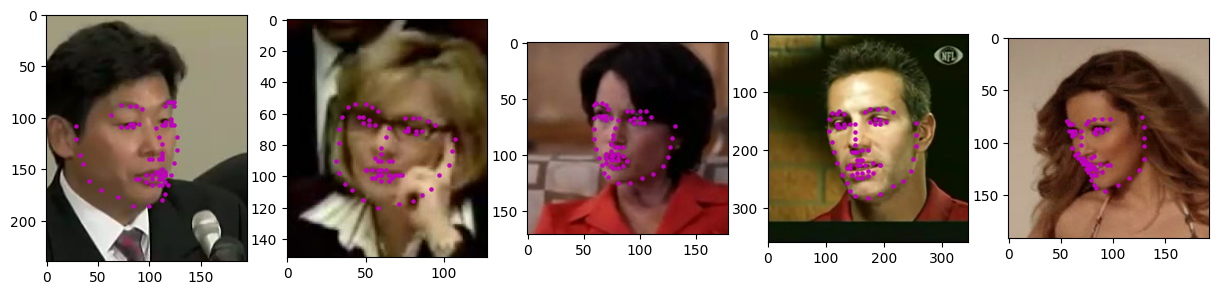

In [10]:
fig = plt.figure(figsize = (15,5))
num_disp = 5
for i in range(num_disp):
  rand_idx = np.random.randint(0,len(face_dataset))
  sample = face_dataset[rand_idx]
  print(i, sample['image'].shape, sample['keypoints'].shape)
  fig.add_subplot(1,num_disp,i+1)
  show_keypoints(sample['image'], sample['keypoints'])

## Transforms
* normalization
* rescale
* random crop
* ToTensor

In [11]:
# normalization
class Normalize(object):
  """Convert a color image to grayscale and normalize the color range to [0,1]."""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
    image = np.copy(image)
    key_pts = np.copy(key_pts)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image/255.0
    key_pts = (key_pts - 100)/50.0
    return {'image': image, 'keypoints': key_pts}

# rescale

class Rescale(object):
  """Rescale the image in a sample to a given size.
  Args:
    output_size (tuple or int): Desired output size. If tuple, output is
    matched to output_size. If int, smaller of image edges is matched
    to output_size keeping aspect ratio the same.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size , self.output_size * w / h
    else:
      new_h, new_w = self.output_size
    new_h, new_w = int(new_h), int(new_w)
    image = cv2.resize(image , (new_w, new_h))
    key_pts = key_pts * [new_w/w, new_h/h]
    return {'image': image, 'keypoints': key_pts}

class RandomCrop(object):
  """ implement random crop in a sample
  Args:
      output_size (tuple or int): Desired output size. If int, square crop
      is made.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2 # check if there are w and h in output_size var
      self.output_size = output_size
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
    h, w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top+new_h, left:left+new_w]
    key_pts = key_pts - [left, top]

    return {'image': image, 'keypoints': key_pts}

class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']

    # if image has no grayscale color channel, add one
    if(len(image.shape) == 2):
      # add that third color dim
      image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))

    return {'image': torch.from_numpy(image),
            'keypoints': torch.from_numpy(key_pts)}



## test transformation

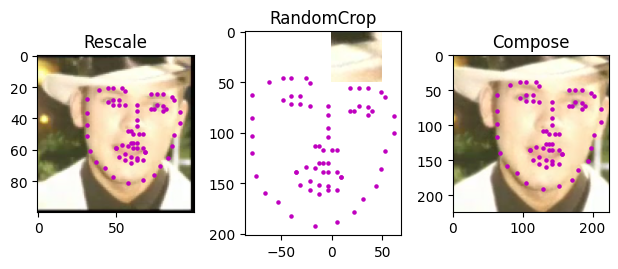

In [12]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 200
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [13]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             transformation=data_transform)

# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())



Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


## loading and batching data

In [14]:
train_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             transformation=data_transform)

test_dataset = FacialKeypointsDataset(csv_file='./P1_Facial_Keypoints/data/test_frames_keypoints.csv',
                                          root_dir='./P1_Facial_Keypoints/data/',
                                             train = False,
                                             transformation=data_transform)

batch_size = 24
train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True, num_workers= 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

# Neural network definition

In [15]:
class Residual_Block(nn.Module):
  def __init__(self, in_channel, out_channel, stride = 1, down_sample = None):
    super(Residual_Block, self).__init__()
    self.convolution1 = nn.Sequential(
                                        # depthwise separable convolution
                                        #depthwise
                                        nn.Conv2d(in_channel, in_channel, kernel_size = 3, stride = stride, padding = 1, groups= in_channel),
                                        # pointwise
                                        nn.Conv2d(in_channel, out_channel, kernel_size = 1, stride = 1, padding = 0,bias=False),
                                        nn.BatchNorm2d(out_channel),
                                        nn.ReLU6()
                                      )
    self.convolution2 = nn.Sequential(
                                        #depthwise separable convolution
                                        #depthwise
                                        nn.Conv2d(out_channel, out_channel, kernel_size = 3, stride = 1, padding = 1,groups = out_channel ),
                                        # pointwise
                                        nn.Conv2d(out_channel, out_channel, kernel_size = 1, stride = 1, padding = 0 ,bias = False),
                                        nn.BatchNorm2d(out_channel),
                                      )
    self.down_sample = down_sample
    self.relu = nn.ReLU6()
    self.out_channel = out_channel

  def forward(self, x):
    residual = x
    out = self.convolution1(x)
    # print(out.shape)
    out = self.convolution2(out)
    # print(out.shape)
    if self.down_sample:
      residual = self.down_sample(x)
    # print(out.shape)
    # print(residual.shape)
    out += residual
    out = self.relu(out)
    return(out)


In [16]:
class Net(nn.Module):
  def __init__(self, block, layers, num_class = 10):
    super(Net, self).__init__()
    self.inplanes= 32
    self.convolution1 = nn.Sequential(
                                        nn.Conv2d(1,3,kernel_size = 7, stride = 2, padding = 3,groups = 1),
                                        nn.Conv2d(3,32,kernel_size = 1, stride = 1, padding = 0, bias = False),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6()
                                      )
    self.maxpool = nn.MaxPool2d( kernel_size = 3, stride = 2, padding = 1)
    self.layer0 = self._make_layer(block, 32, layers[0], stride = 1)
    self.layer1 = self._make_layer(block, 64 , layers[1], stride = 2)
    self.layer2 = self._make_layer(block, 128, layers[2], stride = 2)
    self.layer3 = self._make_layer(block, 256, layers[3], stride = 2)
    # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(256, 64)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(64, 136)
    I.xavier_uniform_(self.fc.weight.data)
    I.xavier_uniform_(self.fc2.weight.data)

  def _make_layer(self, block, planes, blocks, stride=1):
    down_sample = None
    if stride != 1 or self.inplanes != planes :
      down_sample = nn.Sequential(
                                    nn.Conv2d(self.inplanes, self.inplanes, kernel_size = 1, stride = stride, groups = self.inplanes),
                                    nn.Conv2d(self.inplanes, planes, kernel_size = 1, stride = 1, bias = False),
                                    nn.BatchNorm2d(planes)
                                  )
    layers = []
    layers.append(block(self.inplanes, planes, stride, down_sample))
    self.inplanes = planes
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.convolution1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    # print(x.shape)

    x = self.avgpool(x)

    x = self.flatten(x)
    # print(x.shape)
    # x = x.view(x.size(0),-1)
    x = self.fc(x)
    x = self.dropout(x)
    x = self.fc2(x)
    # print(x.shape)
    return x


In [18]:
model = Net(Residual_Block, [2,3,4,2])
summary.summary(model, (1, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 112, 112]             150
            Conv2d-2         [-1, 32, 112, 112]              96
       BatchNorm2d-3         [-1, 32, 112, 112]              64
             ReLU6-4         [-1, 32, 112, 112]               0
         MaxPool2d-5           [-1, 32, 56, 56]               0
            Conv2d-6           [-1, 32, 56, 56]             320
            Conv2d-7           [-1, 32, 56, 56]           1,024
       BatchNorm2d-8           [-1, 32, 56, 56]              64
             ReLU6-9           [-1, 32, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]             320
           Conv2d-11           [-1, 32, 56, 56]           1,024
      BatchNorm2d-12           [-1, 32, 56, 56]              64
            ReLU6-13           [-1, 32, 56, 56]               0
   Residual_Block-14           [-1, 32,

In [19]:
batch_size = 24
learning_rate = 0.0001
epochs = 5
momentum= 0.9

optimizer = optim.Adam
criterion = nn.SmoothL1Loss
# using cross entropy whcih combines softmax and NLL loss
optimizer = optimizer(model.parameters(),lr = learning_rate)
# stochastic gradient descent with a small learning rate AND some momentum
criterion = criterion()


In [20]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % batch_size == batch_size-1:    # print every 24 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [21]:
train_net(100)

Epoch: 1, Batch: 24, Avg. Loss: 0.011621117800474166
Epoch: 1, Batch: 48, Avg. Loss: 0.007117665201425552
Epoch: 1, Batch: 72, Avg. Loss: 0.005570164248347283
Epoch: 1, Batch: 96, Avg. Loss: 0.005194999814033509
Epoch: 1, Batch: 120, Avg. Loss: 0.0043652339875698085
Epoch: 1, Batch: 144, Avg. Loss: 0.004040586650371551
Epoch: 2, Batch: 24, Avg. Loss: 0.00386682391166687
Epoch: 2, Batch: 48, Avg. Loss: 0.0035193025022745134
Epoch: 2, Batch: 72, Avg. Loss: 0.0033943773433566093
Epoch: 2, Batch: 96, Avg. Loss: 0.0034194373190402985
Epoch: 2, Batch: 120, Avg. Loss: 0.0031127037703990936
Epoch: 2, Batch: 144, Avg. Loss: 0.003306366018950939
Epoch: 3, Batch: 24, Avg. Loss: 0.002927323132753372
Epoch: 3, Batch: 48, Avg. Loss: 0.002868785724043846
Epoch: 3, Batch: 72, Avg. Loss: 0.0028448404297232626
Epoch: 3, Batch: 96, Avg. Loss: 0.0029298923164606094
Epoch: 3, Batch: 120, Avg. Loss: 0.0028087451979517935
Epoch: 3, Batch: 144, Avg. Loss: 0.002733324483036995
Epoch: 4, Batch: 24, Avg. Loss: 0

KeyboardInterrupt: 

## save model

In [30]:
! mkdir saved_models
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'
torch.save(model.state_dict(), model_dir+model_name)


## test model

0 (224, 224) (68, 2)
1 (224, 224) (68, 2)
2 (224, 224) (68, 2)
3 (224, 224) (68, 2)
4 (224, 224) (68, 2)


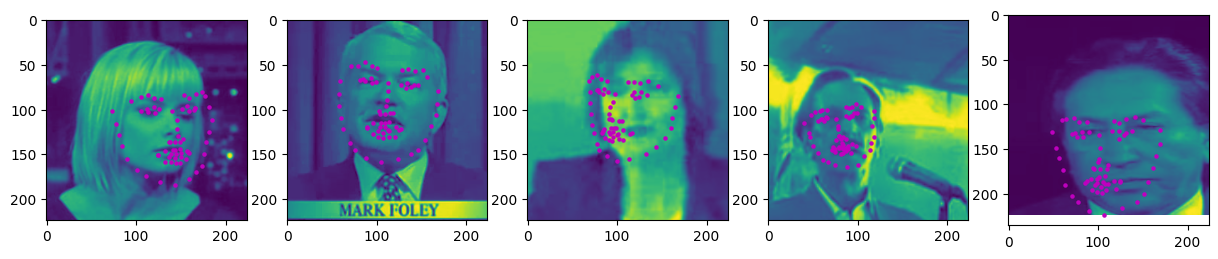

In [41]:
model.eval()

test_iter = test_loader.__iter__()
data = test_iter._next_data()
images = data['image']
np_img = np.squeeze(images.numpy())
key_pts = data['keypoints']

# flatten pts
key_pts = key_pts.view(key_pts.size(0), -1)

# convert variables to floats for regression loss
key_pts = key_pts.type(torch.FloatTensor)
images = images.type(torch.FloatTensor)

# forward pass to get outputs
output_pts = model(images)

pts = (np.squeeze(output_pts.data.numpy()).reshape(batch_size,-1,2) *50.0 ) +100
main_pts = (np.squeeze(key_pts.data.numpy()).reshape(batch_size,-1,2) *50.0 ) +100
fig = plt.figure(figsize = (15,5))
num_disp = 5
for i in range(num_disp):
  sample_img = np_img[i]
  sample_pts = pts[i]
  sample_main_pts = main_pts[i]
  print(i, sample_img.shape, sample_pts.shape)
  fig.add_subplot(1,num_disp,i+1)
  show_keypoints(sample_img, sample_pts)


In [31]:
pts.shape

(1, 68, 2)

## download files

In [32]:
from google.colab import files
import zipfile

!zip -r saved_models.zip saved_models

files.download('saved_models.zip')

  adding: saved_models/ (stored 0%)
  adding: saved_models/keypoints_model_1.pt (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Face and Keypoint detection

(-0.5, 758.5, 499.5, -0.5)

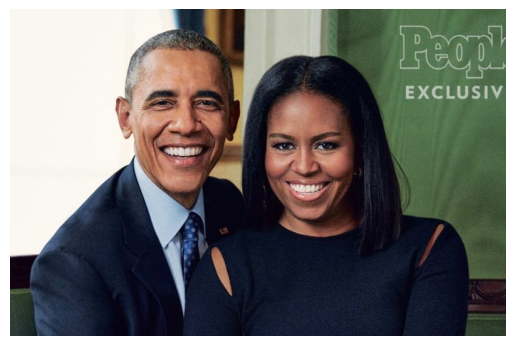

In [42]:
img = mpimg.imread("obamas.jpg")
plt.imshow(img)
plt.axis("off")

# detecting faces

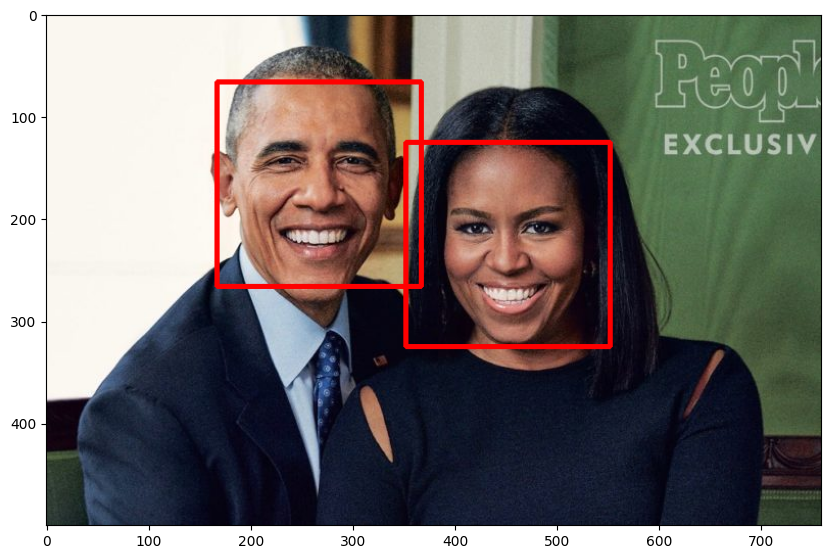

In [86]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('P1_Facial_Keypoints/detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img, 1.7, 2)

# make a copy of the original image to plot detections on
image_with_detections = img.copy()

faces_vec = []
tens= []
# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)

    x_min = x - int(w * 0.25)
    x_max = x + int(w * 1.25)
    y_min = y - int(h * 0.25)
    y_max = y + int(h *1.25)
    if x_min < 0:
      x_min = 0
    if y_min < 0:
      y_min = 0
    if x_max > img.shape[1]:
      x_max = img.shape[1]
    if y_max > img.shape[0]:
      y_max = img.shape[0]
    photo = img[y_min:y_max,x_min:x_max]

    tens.append( {"image": photo , "keypoints":np.ones((68,2))})
    faces_vec.append(photo)


fig = plt.figure(figsize=(10,10))

plt.imshow(image_with_detections)

array([[[250, 247, 240],
        [250, 247, 240],
        [250, 247, 240],
        ...,
        [195, 197, 184],
        [195, 197, 184],
        [194, 196, 183]],

       [[250, 247, 240],
        [250, 247, 240],
        [250, 247, 240],
        ...,
        [195, 197, 184],
        [195, 197, 184],
        [197, 199, 186]],

       [[250, 247, 240],
        [250, 247, 240],
        [250, 247, 240],
        ...,
        [194, 196, 183],
        [194, 196, 183],
        [195, 197, 184]],

       ...,

       [[ 59,  76, 104],
        [ 59,  75, 101],
        [ 59,  75, 101],
        ...,
        [ 12,   2,  13],
        [ 16,   5,  13],
        [ 27,  11,  14]],

       [[ 50,  65,  94],
        [ 49,  65,  91],
        [ 49,  65,  91],
        ...,
        [ 13,   3,  14],
        [ 19,   8,  16],
        [ 30,  14,  15]],

       [[ 53,  68,  97],
        [ 52,  68,  94],
        [ 52,  68,  94],
        ...,
        [ 15,   5,  16],
        [ 23,  10,  19],
        [ 37,  18,  20]]], dtype=uint8)
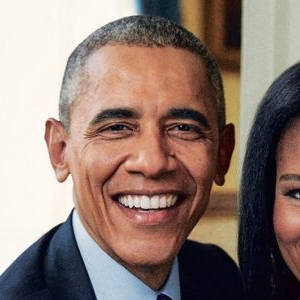

In [87]:
faces_vec[0]

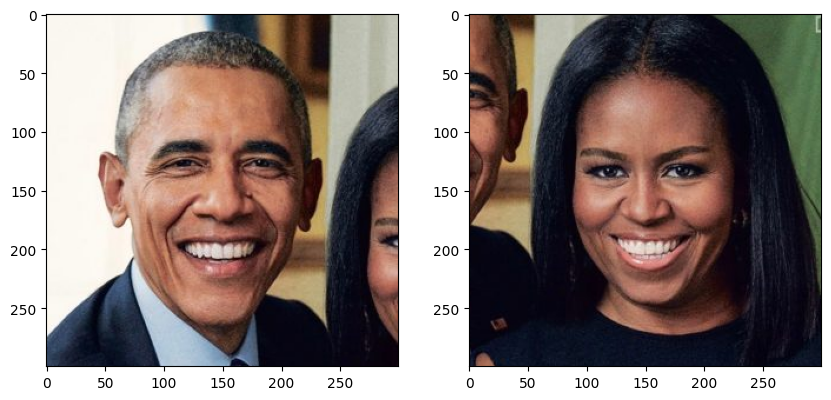

In [88]:
fig = plt.figure(figsize=(10,5))
for idx in range(len(faces_vec)):
  ax = fig.add_subplot(1,len(faces_vec),idx+1)
  ax.imshow(faces_vec[idx])


## convert images

In [89]:
rescaler = Rescale(250)
random_crop = RandomCrop(224)
normalization = Normalize()
to_tensor = ToTensor()
face_tensor = []
for face in tens:
  face = rescaler(face)
  face = random_crop(face)
  face = normalization(face)
  face = to_tensor(face)
  face_tensor.append(face)


## load model

In [90]:
# load model
model = Net(Residual_Block, [2,3,4,2])
model.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
##  prepare model for testing
model.eval()


<ipython-input-90-8d697a1cee68>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))


Net(
  (convolution1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU6()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): Residual_Block(
      (convolution1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU6()
      )
      (convolution2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, a

torch.Size([1, 1, 224, 224])
0 (224, 224) (68, 2)
torch.Size([1, 1, 224, 224])
1 (224, 224) (68, 2)


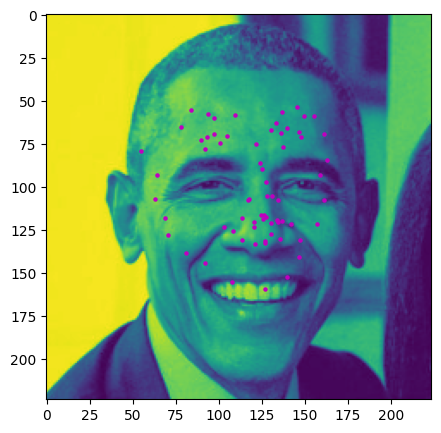

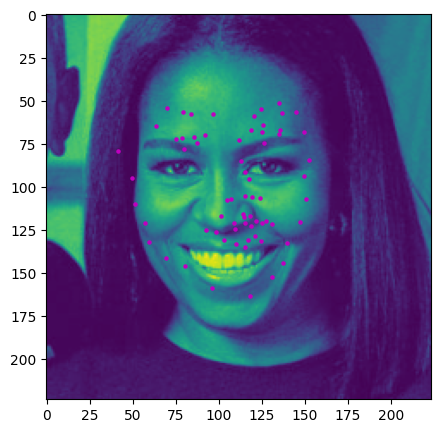

In [91]:
model.eval()

for idx,face in enumerate(face_tensor):
  images = torch.unsqueeze(face['image'],0)
  print(images.shape)
  np_img = np.squeeze(images.numpy())

  # convert variables to floats for regression loss
  images = images.type(torch.FloatTensor)

  # forward pass to get outputs
  output_pts = model(images)

  pts = (np.squeeze(output_pts.data.numpy()).reshape(1,-1,2) *50.0 ) +100
  fig = plt.figure(figsize = (15,5))
  sample_img = np_img
  sample_pts = pts[0]
  print(idx, sample_img.shape, sample_pts.shape)
  fig.add_subplot(1,len(face_tensor),idx+1)
  show_keypoints(sample_img, sample_pts)
